## import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re
import random
import time

import torch
from torchtext.legacy import data
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import(TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load Dataset

In [3]:
train = pd.read_csv("train.csv", encoding='CP949')
test = pd.read_csv("test.csv", encoding='CP949')
sub = pd.read_csv("sample.csv", encoding='CP949')

# EDA

## 데이터셋 확인 작업

In [4]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [5]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [6]:
sub.head()

,index,label
0,0,contradiction
1,1,contradiction
2,2,entailment
3,3,neutral
4,4,neutral


# 갯수 확인

In [7]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)


train 19996 개
test 5000 개

# 중복값 확인

In [8]:
train.drop_duplicates(subset = ['premise','hypothesis'],inplace = True)
test.drop_duplicates(subset = ['premise','hypothesis'],inplace = True)

In [9]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (19996, 4) 
test shape => (5000, 3)


중복 값 없음


# 데이터 결측치 계산

In [10]:
train.isnull().sum()

index         0
premise       0
hypothesis    0
label         0
dtype: int64

## 라벨값이 balanced 한지 확인 하는 시각화 작업

막대 그래프

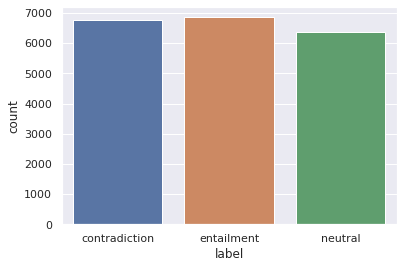

In [11]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

원그래프

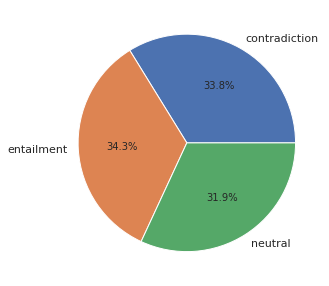

In [12]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

# 결과 도출

데이터들이 골고루 잘 분포되어 있음

### LabelEncoder를 활용해 categorical features를 encode함
contradiction => 0  
entailment => 1  
neutral => 2

In [13]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])

In [14]:
text = train.premise + train.hypothesis

### premise, hypothesis 합치기

In [15]:
# Concatenate and label data
texts = np.array(train.premise + train.hypothesis)
labels = np.array(train.label)

# tokenizer

In [16]:
from konlpy.tag import Mecab
word_tokenize = Mecab()

In [17]:
from icu_tokenizer import Tokenizer
tokenizer = Tokenizer(lang='ko')

### 훈련에 사용할 데이터로 변환

In [18]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA TITAN RTX


# Data Tokenzier

In [19]:
def tokenize(texts):

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = tokenizer.tokenize(sent)
        print(tokenized_sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

# Load Pretrained Vectors

In [20]:
import io
from tqdm.notebook import tqdm

def load_pretrained_vectors(word2idx, fname):

    print("Loading pretrained vectors...")
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [22]:
tokenized_texts, word2idx, max_len = tokenize(texts)

['삼성은', '자작극을', '벌인', '2', '명에게', '형사', '고소', '등의', '법적', '대응을', '검토', '중이라고', '하였으나', ',', '중국', '내에서의', '여론은', '자작극이라는', '증거가', '충분함에도', '불구하고', '좋지', '않다', '.', '자작극을', '벌인', '이는', '3', '명이다', '.']
['이를', '위해', '예측적', '범죄예방', '시스템을', '구축하고', '고도화한다', '.', '예측적', '범죄예방', '시스템', '구축하고', '고도화하는', '것은', '목적이', '있기', '때문이다', '.']
['광주광역시가', '재개발', '정비사업', '원주민들에', '대한', '종합대책을', '마련하는', '등', '원주민', '보호에', '적극', '나섰다', '.', '원주민들은', '종합대책에', '만족했다', '.']
['진정', '소비자와', '직원들에게', '사랑', '받는', '기업으로', '오래', '지속되고', '싶으면', ',', '이런', '상황에서는', '책임', '있는', '모습을', '보여주는', '것이', '필요하다', '.', '이런', '상황에서', '책임', '있는', '모습을', '보여주는', '기업은', '아주', '드물다', '.']
['이번', '증설로', '코오롱인더스트리는', '기존', '생산량', '7', '만', '7000', '톤에서', '1', '만', '6800', '톤이', '늘어나', '총', '9', '만', '3800', '톤의', '생산', '능력을', '확보하게', '됐다', '.', '코오롱', '인더스트리는', '총', '9', '만', '3800', '톤의', '생산', '능력을', '확보했다', '.']
['자신뿐만', '아니라', '남을', '돕고자', '하는', '청년의', '꿈과', '열정에', '모두가', '주목하고', '있다', '.', '모든', '청년은', '꿈과', '열정을', '가지고', '있다'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
input_ids = encode(tokenized_texts, word2idx, max_len)

# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/cc.ko.300.vec")
embeddings = torch.tensor(embeddings)

Loading pretrained vectors...


0it [00:00, ?it/s]

There are 50017 / 63371 pretrained vectors found.


# Train, Val Data Load

In [24]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Specify batch_size
    batch_size = 50

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [25]:
#train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

 ## Create CNN Model

For simplicity, the model above has very small configurations. The final model we'll use is much bigger but has the same architecture:

|Description         |Values           |
|:------------------:|:---------------:|
|input word vectors  |fastText         |
|embedding size      |300              |
|filter sizes        |(100)        |
|num filters         |(500)  |
|activation          |ReLU             |
|pooling             |1-max pooling    |
|dropout rate        |0.5              |
|Optimizer           | Adadelta        |

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=3,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

## Optimizer

In [27]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[10],
                    num_filters=[500],
                    num_classes=3,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=3,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

## LOSS

In [28]:
loss_fn = nn.CrossEntropyLoss()

In [29]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [30]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [31]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=len(word2idx),
                                      embed_dim=300,
                                      learning_rate=0.25,
                                      dropout=0.5)
train(cnn_rand, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


/home/twogudack/anaconda3/envs/tensor/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


   1    |   1.117562   |  1.109427  |   34.05   |   3.30   
   2    |   1.052009   |  1.149304  |   30.90   |   3.15   
   3    |   0.975697   |  1.214750  |   24.75   |   3.12   
   4    |   0.869013   |  1.347666  |   24.25   |   3.22   
   5    |   0.758272   |  1.469777  |   22.75   |   3.14   
   6    |   0.640872   |  1.606693  |   24.05   |   3.24   
   7    |   0.547797   |  1.751188  |   22.15   |   3.20   
   8    |   0.455620   |  1.869943  |   22.20   |   3.24   
   9    |   0.387797   |  1.987640  |   23.05   |   3.18   
  10    |   0.329491   |  2.111465  |   22.10   |   3.17   
  11    |   0.282807   |  2.291693  |   22.25   |   3.26   
  12    |   0.245414   |  2.337873  |   22.15   |   3.19   
  13    |   0.216409   |  2.475454  |   23.30   |   3.21   
  14    |   0.189967   |  2.559243  |   23.00   |   3.13   
  15    |   0.167076   |  2.627968  |   22.75   |   3.12   
  16    |   0.147899   |  2.731571  |   23.45   |   3.22   
  17    |   0.131852   |  2.852077  |   

In [32]:
# CNN-static: fastText pretrained word vectors are used and freezed during training.
set_seed(42)
cnn_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                        freeze_embedding=True,
                                        learning_rate=0.25,
                                        dropout=0.5)
train(cnn_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.092976   |  1.073117  |   41.80   |   1.24   
   2    |   1.047241   |  1.060789  |   42.10   |   1.23   
   3    |   1.006136   |  1.066653  |   42.60   |   1.23   
   4    |   0.956555   |  1.081514  |   41.45   |   1.27   
   5    |   0.893709   |  1.105604  |   39.95   |   1.23   
   6    |   0.814639   |  1.152516  |   37.60   |   1.22   
   7    |   0.723961   |  1.247987  |   36.70   |   1.25   
   8    |   0.618705   |  1.360998  |   35.80   |   1.29   
   9    |   0.520796   |  1.415104  |   35.30   |   1.28   
  10    |   0.428780   |  1.498336  |   34.45   |   1.24   
  11    |   0.352636   |  1.595640  |   33.70   |   1.28   
  12    |   0.297019   |  1.712094  |   33.55   |   1.25   
  13    |   0.245901   |  1.842457  |   33.60   |   1.24   
  14    |   0.207508   |  1.924081  |   33.30   |   1.21   
  15    |   0.178308

In [ ]:
# CNN-non-static: fastText pretrained word vectors are fine-tuned during training.
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   1.091819   |  1.068913  |   42.40   |   4.80   
   2    |   1.042269   |  1.052814  |   43.55   |   4.76   
   3    |   0.993350   |  1.051256  |   43.80   |   4.86   
   4    |   0.928901   |  1.066253  |   42.90   |   4.84   
   5    |   0.839841   |  1.099485  |   42.30   |   4.79   
   6    |   0.726140   |  1.164346  |   41.70   |   4.79   
   7    |   0.593425   |  1.284678  |   40.60   |   4.79   
   8    |   0.446353   |  1.444503  |   38.25   |   4.79   
   9    |   0.321615   |  1.564071  |   38.80   |   4.78   
  10    |   0.221852   |  1.713664  |   39.45   |   4.78   
  11    |   0.151660   |  1.873004  |   39.60   |   4.77   
  12    |   0.108958   |  2.028876  |   38.95   |   4.76   
  13    |   0.079549   |  2.166878  |   38.65   |   4.77   
  14    |   0.060657   |  2.314877  |   38.20   |   4.78   
  15    |   0.046290